## Demonstration of Plots

In [ ]:
import numpy as np
import os, json, cv2, random
import re
import numpy as np
import json
import ast
from collections import defaultdict
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import textwrap

In [44]:
# Setting MLFLOW Configurations (KEY SHARED FOR SIMPLICITY; PRECAUTIONS APPLIED)
os.environ['MLFLOW_TRACKING_USERNAME'] = 'thesisuist'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cd6a7567bea2de310e1d52ac2f35483fca241e95' 

In [45]:
# Setting the tracking URI: DagsHub MLFlow repository
mlflow.set_tracking_uri('https://dagshub.com/thesisuist/reversed_final.mlflow')

# Getting the Run ID
run_id = 'd9dc1aed5c8044758193a76caa589ba7'

# Saving the list of all the artifacts
artifacts = mlflow.tracking.MlflowClient().list_artifacts(run_id)


In [46]:
# Printing the artifact files of the chosen experiment
artifacts

[<FileInfo: file_size=None, is_dir=True, path='after_train_config_file'>,
 <FileInfo: file_size=131971, is_dir=False, path='events.out.tfevents.1715871592.gorina8.1113931.0'>,
 <FileInfo: file_size=15, is_dir=False, path='last_checkpoint'>,
 <FileInfo: file_size=34526, is_dir=False, path='loss_curve.png'>,
 <FileInfo: file_size=87759, is_dir=False, path='metrics.json'>,
 <FileInfo: file_size=6053, is_dir=False, path='model-config.yaml'>,
 <FileInfo: file_size=330107348, is_dir=False, path='model_0000499.pth'>,
 <FileInfo: file_size=330107348, is_dir=False, path='model_0000999.pth'>,
 <FileInfo: file_size=330107348, is_dir=False, path='model_0001499.pth'>,
 <FileInfo: file_size=330107348, is_dir=False, path='model_0001999.pth'>,
 <FileInfo: file_size=330107348, is_dir=False, path='model_0002499.pth'>,
 <FileInfo: file_size=330107348, is_dir=False, path='model_final.pth'>,
 <FileInfo: file_size=None, is_dir=True, path='test-set-results'>,
 <FileInfo: file_size=None, is_dir=True, path='te

In [47]:
# Downloading the metrics from the artifact
run_id = 'd9dc1aed5c8044758193a76caa589ba7' # Run ID for P1E1
mlflow.tracking.MlflowClient().download_artifacts(run_id, 'metrics.json', 'artifacts')

'/mnt/beegfs/home/aashishk/for_github/notebooks/artifacts/metrics.json'

#### Loss Function

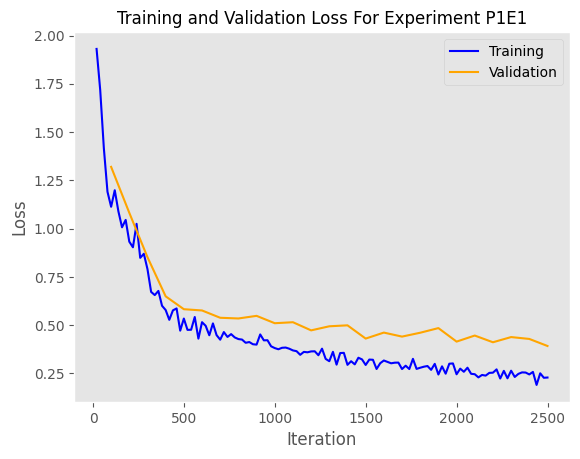

In [48]:
# Reading the metrics data
metrics_df = pd.read_json("artifacts/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")

fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="blue", label="Train") 
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="orange", label="Validation")  

ax.legend(['Training', 'Validation'], fontsize=10)

plt.grid()
ax.set_title("Training and Validation Loss For Experiment P1E1",fontsize=12)
ax.set_ylabel("Loss",fontsize=12)  # Set y-axis title
ax.set_xlabel("Iteration",fontsize=12)  # Set x-axis title

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()

## Statistic of Phase Dataset

#### Count Classes Across All Phases

In [49]:
def count_classes_phases_dataset(filenames, sets):
    '''
    Counts the occurrences of each class in a dataset across different sets.

    Args:
        filenames (list): A list of filenames containing JSON data for each set.
        sets (list): A list of set names corresponding to each filename.

    Returns:
        dict: A dictionary containing aggregate counts of classes for each set.
    '''
    
    # Initializing the counters
    aggregate_set_counts = {set_name: {} for set_name in sets}

    for filename, set_name in zip(filenames, sets):
        # Loading JSON data from a file
        with open(filename, 'r') as file:
            data = json.load(file)

        # Extractng relevant data from JSON
        images = data['images']
        annotations = data['annotations']
        categories = data['categories']

        # Initializing counters for each class
        class_counts = {category['name']: 0 for category in categories}

        # Counting the occurrences of each class
        for image in images:
            image_id = image['id']
            
            # Count classes for each image
            for annotation in annotations:
                if annotation['image_id'] == image_id:
                    category_id = annotation['category_id']
                    category_name = next(category['name'] for category in categories if category['id'] == category_id)
                    class_counts[category_name] += 1

        # Storing the counts for this set
        aggregate_set_counts[set_name] = class_counts

    print("Aggregate Set Counts:", aggregate_set_counts)
    return aggregate_set_counts


In [50]:
def plot_counts_phases_data(filenames, sets, figure_title=""):
    '''
    Generates bar charts illustrating the counts of classes across different sets.

    Args:
        filenames (list): A list of filenames containing JSON data for each set.
        sets (list): A list of set names corresponding to each filename.
        figure_title (str, optional): Title for the plot (default is an empty string).
    '''
    
    # Getting the counts of classes from the provided JSON files
    aggregate_set_counts = count_classes_phases_dataset(filenames, sets)
        
    plt.style.use('ggplot')  # Set the plot style to 'ggplot'

    labels = list(aggregate_set_counts[sets[0]].keys())
    x = np.arange(len(labels)) * 2 
    width = 0.35 

    fig, ax = plt.subplots()
    cmap = plt.get_cmap('Dark2')  # Use the Dark2 qualitative colormap

    color_range = np.linspace(0, 0.3, len(sets))  # Define a range of colors

    for i, (set_name, color) in enumerate(zip(sets, color_range), start=1):
        counts = list(aggregate_set_counts[set_name].values())
        ax.bar(x + width * (i - 2), counts, width, label=set_name, color=cmap(color))

    ax.set_xlabel('Classes', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'})
    ax.set_ylabel('Counts', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'})
    ax.set_title(figure_title, fontdict={'fontsize': 14, 'fontfamily': 'serif', "color": 'black'})

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(labels, fontdict={'fontsize': 11, 'fontfamily': 'serif', "color": 'black'})
    ax.tick_params(axis='y', labelcolor='black')

    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for text in legend.get_texts():
        text.set_fontsize(10)
        text.set_color("black")
        text.set_fontfamily('serif')

    plt.show()


## Class Specific Counts

#### Phase I

Aggregate Set Counts: {'Training Set': {'caption': 136, 'table': 140, 'table_caption': 136}, 'Validation Set': {'caption': 35, 'table': 35, 'table_caption': 35}, 'Test Set': {'caption': 35, 'table': 34, 'table_caption': 33}}


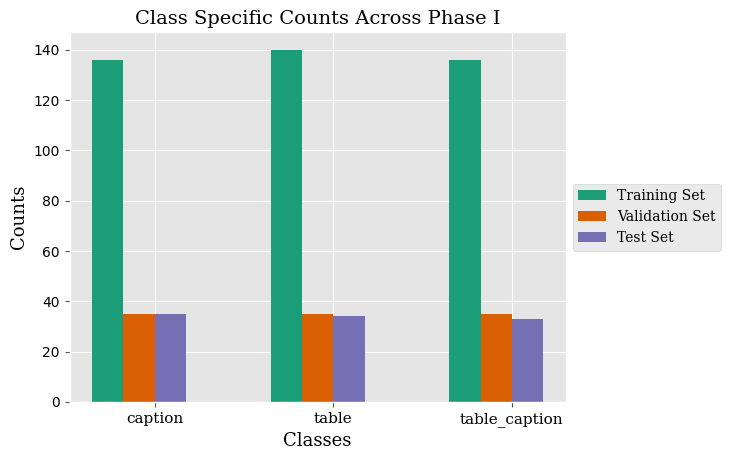

In [51]:
filenames = ["../data/Phase I/train.json","../data/Phase I/val.json","../data/Phase I/test.json"]
sets = ['Training Set', 'Validation Set', 'Test Set']
plot_counts_phases_data(filenames, sets, "Class Specific Counts Across Phase I")

#### Phase II

Aggregate Set Counts: {'Training Set': {'caption': 998, 'table': 1008, 'table_caption': 971}, 'Validation Set': {'caption': 196, 'table': 196, 'table_caption': 196}, 'Test Set': {'caption': 192, 'table': 194, 'table_caption': 190}}


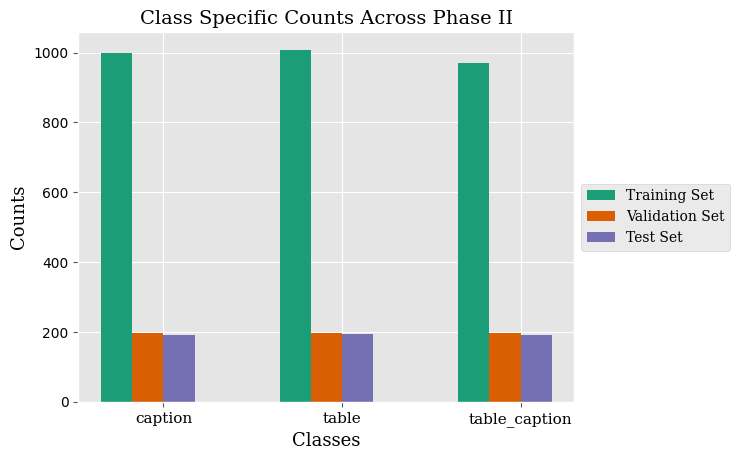

In [52]:
filenames = ["../data/Phase II/train.json","../data/Phase II/val.json","../data/Phase II/test.json"]
sets = ['Training Set', 'Validation Set', 'Test Set']
plot_counts_phases_data(filenames, sets, "Class Specific Counts Across Phase II")

#### Phase III

Aggregate Set Counts: {'Training Set': {'caption': 1771, 'table': 1790, 'table_caption': 1724}, 'Validation Set': {'caption': 350, 'table': 349, 'table_caption': 349}, 'Test Set': {'caption': 350, 'table': 352, 'table_caption': 348}}


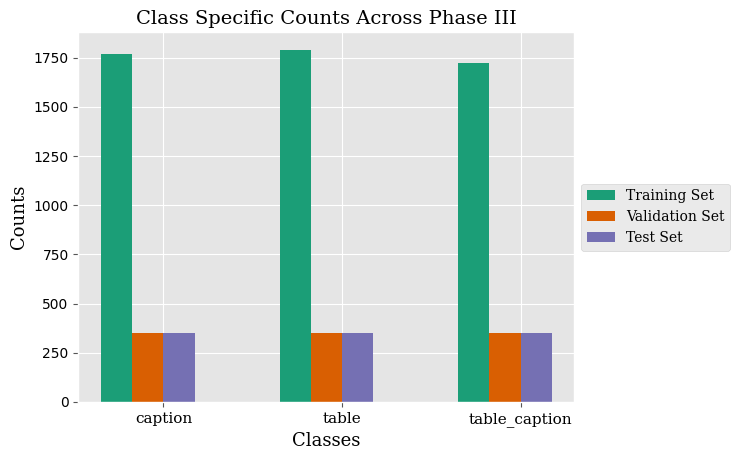

In [53]:
filenames = ["../data/Phase III/whole_dataset/faster/train_whole.json","../data/Phase III/whole_dataset/faster/val_whole.json","../data/Phase III//whole_dataset/faster/test_whole.json"]
sets = ['Training Set', 'Validation Set', 'Test Set']
plot_counts_phases_data(filenames, sets, "Class Specific Counts Across Phase III")

## Class Specific Counts for Layout Dataset

In [54]:
def count_skewed_layout(filenames, skewed_layout=["onecol", "twocol", "merged"]):
    '''
    Aggregates counts of specific layout types and their associated classes from JSON files.

    Args:
        filenames (list): A list of filenames containing JSON data for each set.
        skewed_layout (list, optional): A list of layout types to count.

    Returns:
        tuple: Contains two dictionaries:
            - Aggregate class counts for each layout type.
    '''
    
    # Initializing aggregate counters for each layout type and class
    aggregate_count_types = {layout: 0 for layout in skewed_layout}
    aggregate_category_counts = {layout: {} for layout in skewed_layout}

    for filename in filenames:
        # Loading JSON data from a file
        with open(filename, 'r') as file:
            data = json.load(file)

        # Extracting relevant data from JSON
        images = data['images']
        annotations = data['annotations']
        categories = data['categories']

        # Initializing counters for each layout type and class for this file
        count_types = {layout: 0 for layout in skewed_layout}
        category_counts = {layout: {category['name']: 0 for category in categories} for layout in skewed_layout}

        # Counting the occurrences of each layout type and class
        for image in images:
            file_name = image['file_name']
            image_id = image['id']
            
            for layout in skewed_layout:
                if layout in file_name:
                    count_types[layout] += 1
                    # Count classes for matching image_id
                    for annotation in annotations:
                        if annotation['image_id'] == image_id:
                            category_id = annotation['category_id']
                            category_name = next(category['name'] for category in categories if category['id'] == category_id)
                            category_counts[layout][category_name] += 1

        # Aggregating the counts from this file to the overall counts
        for layout in skewed_layout:
            aggregate_count_types[layout] += count_types[layout]
            for category in category_counts[layout]:
                if category in aggregate_category_counts[layout]:
                    aggregate_category_counts[layout][category] += category_counts[layout][category]
                else:
                    aggregate_category_counts[layout][category] = category_counts[layout][category]

    # Mapping for layout name changes
    layout_name_mapping = {
        skewed_layout[0]: "Single-Column Layout",
        skewed_layout[1]: "Two-Columns Layout",
        skewed_layout[2]: "Hybrid Layout"
    }

    # Transforming the final counts with the new names
    transformed_category_counts = {layout_name_mapping[layout]: counts for layout, counts in aggregate_category_counts.items()}

    return transformed_category_counts


In [55]:
import textwrap

def wrap_text(text, width):
    '''
    Wraps text to a specified width.

    Args:
        text (str): The text to wrap.
        width (int): The maximum line width.
    Returns:
        str: The wrapped text.
    '''
    
    return "\n".join(textwrap.wrap(text, width))

In [56]:
def plot_counts_skewed_layouts(filenames, skewed_layout=["onecol", "twocol", "merged"], figure_title=""):
    '''
    Plots bar charts illustrating the counts of categories across different skewed layouts.

    Args:
        filenames (list): A list of filenames containing JSON data for each set.
        skewed_layout (list, optional): A list of layout types to plot.
        figure_title (str, optional): Title for the plot.
    '''
    
    # Getting the counts of skewed layouts from the provided JSON files
    counts_skewed_layouts = count_skewed_layout(filenames, skewed_layout)
    
    plt.style.use('ggplot')  # Set the plot style to 'ggplot'

    # Extracting the categories (classes) and layouts (legends)
    categories = list(next(iter(counts_skewed_layouts.values())).keys())
    layouts = list(counts_skewed_layouts.keys())

    x = np.arange(len(categories)) * 2  # Add space between classes
    width = 0.35  # Adjust the width of each bar

    fig, ax = plt.subplots()
    cmap = plt.get_cmap('Dark2')  # Use the Dark2 qualitative colormap

    # Plotting bars for each layout and category
    for i, layout in enumerate(layouts):
        counts = [counts_skewed_layouts[layout][category] for category in categories]
        ax.bar(x + width * i, counts, width, label=layout, color=cmap.colors[i])

    # Setting x-axis label with customized font properties
    ax.set_xlabel('Classes', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'})
    # Set y-axis label with customized font properties
    ax.set_ylabel('Counts', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'})

    # Adjusting the position of ticks and their labels
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, fontdict={'fontsize': 11, 'fontfamily': 'serif', "color": 'black'})
    ax.tick_params(axis='y', labelcolor='black')
    
    # Wrapping and set the title of the plot
    wrapped_title = wrap_text(figure_title, 50)  # Adjust the width as necessary
    plt.title(wrapped_title, fontsize=13, fontfamily='serif', color='black')

    # Adjusting legend font style
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for text in legend.get_texts():
        text.set_fontsize(10)
        text.set_color("black")
        text.set_fontfamily('serif')

    plt.show()



## Single-Column

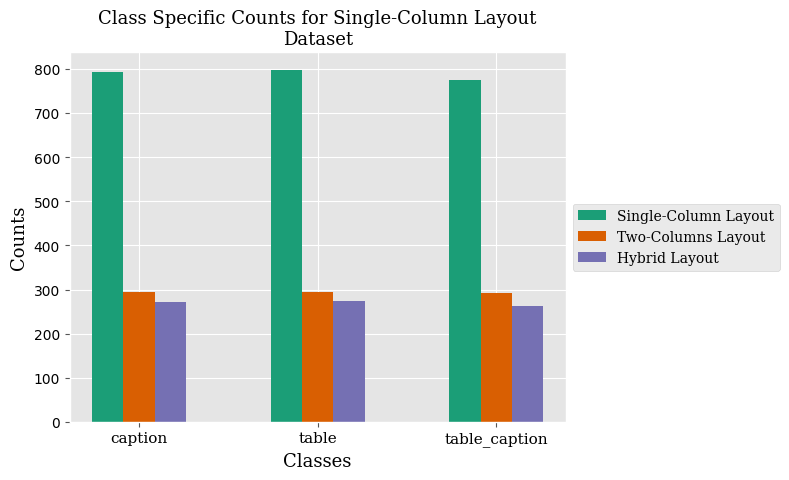

In [57]:
filenames = ['../data/Phase III/skewed/skewed_train_json/train_singlecol_skewed.json', '../data/Phase III/skewed/skewed_val_json/val_singlecol_skewed.json', '../data/Phase III/skewed/skewed_test_json/test_singlecol_skewed.json']
plot_counts_skewed_layouts(filenames, ["singlecol", "twocol", "hybrid"],"Class Specific Counts for Single-Column Layout Dataset") # "Class Specific Counts for Single-Column Layout Dataset")

## Two-Columns 

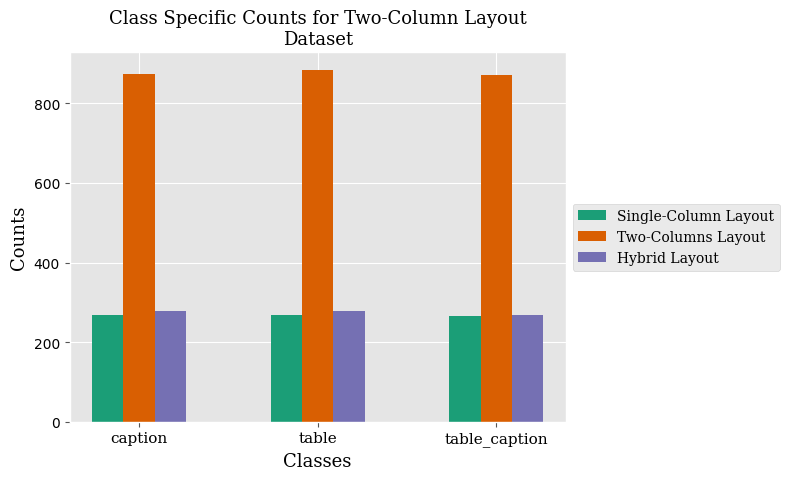

In [58]:
filenames = ['../data/Phase III/skewed/skewed_train_json/train_twocol_skewed.json', '../data/Phase III/skewed/skewed_val_json/val_twocol_skewed.json', '../data/Phase III/skewed/skewed_test_json/test_twocol_skewed.json']
plot_counts_skewed_layouts(filenames, ["singlecol", "twocol", "hybrid"],"Class Specific Counts for Two-Column Layout Dataset") # "Class Specific Counts for Single-Column Layout Dataset")

## Hybrid

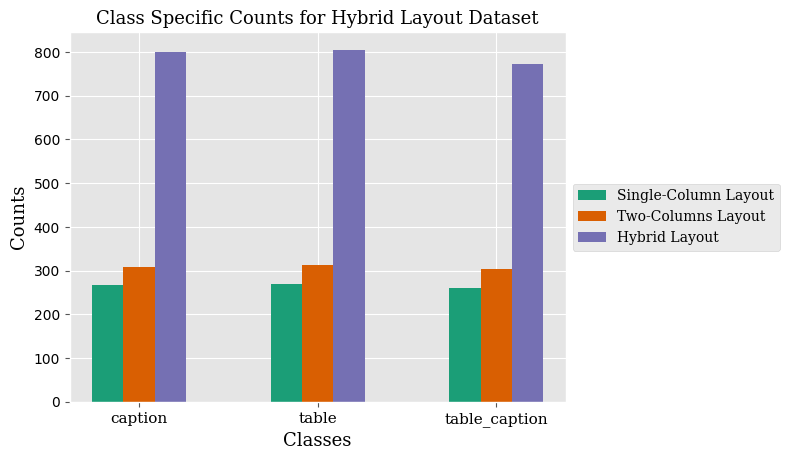

In [59]:
filenames = ['../data/Phase III/skewed/skewed_train_json/train_hybrid_skewed.json', '../data/Phase III/skewed/skewed_val_json/val_hybrid_skewed.json', '../data/Phase III/skewed/skewed_test_json/test_hybrid_skewed.json']
plot_counts_skewed_layouts(filenames, ["singlecol", "twocol", "hybrid"],"Class Specific Counts for Hybrid Layout Dataset") 

## Metrics Bar Plots

In [60]:
def extract_metrics_values(file_path):
    '''
    Extracts the metrics values.

    Args:
        file_path (str): File Path to extract the values.

    Returns:
        tuple: A tuple of two lists:
               - The first list contains keys corresponding to metrics.
               - The second list contains the corresponding metrics values.  
    '''
    with open(file_path, "r") as file:
        text = file.read()

    pattern = r"'bbox', \{[^}]+\}"
    match = re.search(pattern, text)

    if match:
        extracted_part = match.group(0)
        extracted_part = extracted_part.replace("'", '"').replace("nan", "None")
        bbox_dict = ast.literal_eval(extracted_part)
    else:
        print("Pattern not found in the text.")
        return []
    
    
    # Key mapping for "AP" to "mAP"
    key_mapping = {
        "AP": "mAP"
    }

    # List of keys to return values for
    keys_to_return = ["AP", "AP-caption", "AP-table", "AP-table_caption"]

    # Extracting values
    values = [bbox_dict[1].get(key, None) for key in keys_to_return]
    
    # Mapping the key "AP" to "mAP"
    keys_to_plot_filtered = [key_mapping.get(key, key) for key in keys_to_return]
    values_filtered = [value for value in values if value is not None]

    return keys_to_plot_filtered, values_filtered

In [61]:
def plot_metrics(file_paths, bar_width=1, colormap='Dark2', custom_colors=None, x_labels=None, xlabel='Category', ylabel='mAP', title='Plot Title', title_wrap_width=50):
    all_keys = []
    all_values = []

    for file_path in file_paths:
        keys, values = extract_metrics_values(file_path)
        all_keys.append(keys)
        all_values.append(values)

    plt.style.use('ggplot')
    num_experiments = len(file_paths)
    num_classes = len(all_keys[0])
    space_between_bars = 0.6
    x = np.arange(num_experiments) * (bar_width + space_between_bars)

    # Using the specified colormap or custom colors
    if custom_colors:
        colors = custom_colors
    else:
        cmap = plt.get_cmap(colormap)
        colors = cmap(np.linspace(0, 1, num_experiments))

    for i, values in enumerate(all_values):
        offset = (i - (num_experiments - 1) / 2) * bar_width
        plt.bar(x[i], values[0], width=bar_width, color=colors[i])
        plt.text(x[i], values[0], f'{values[0]:.2f}', ha='center', va='bottom', fontsize=10, fontfamily='serif', color='black')

    plt.xlabel(xlabel, fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'}) 
    plt.ylabel(ylabel, fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'}) 

    wrapped_title = wrap_text(title, title_wrap_width) 
    plt.title(wrapped_title, fontsize=12, fontfamily='serif', color='black') 

    if x_labels is None:
        x_labels = [f'C{i}' for i in range(num_experiments)] 

    plt.xticks(x, x_labels, rotation=0, ha='center', fontsize=10, fontfamily='serif', color='black')  
    plt.yticks(np.arange(0, max(max(all_values)) + 10, 10), fontsize=10, fontfamily='serif', color='black') 

    plt.gca().margins(x=0.05) 
    plt.subplots_adjust(bottom=0.2) 

    plt.show()

## Freezing Stages Experiments

#### Faster-RCNN ResNet50 

In [62]:
run_ids = ['1aa8f80774144459ae3cae8467ea1753', '6c60434569a64bad83433da7764bf39b', 
           'e6b1481ce8874bd8b795a91d6c2622ce', '1db3e316180346faa425fab88d0aea1b', 
           'b6cbb3d1f54042f8a824e0b1b59ae442']

file_to_fetch = 'test-set-results/coco-metrics.txt'
filename = 'coco-metrics.txt'
destination = 'artifacts/test-set-results/'

for index, run in enumerate(run_ids):
    # Downloading the artifacts from the current run
    mlflow.tracking.MlflowClient().download_artifacts(run, file_to_fetch, 'artifacts')

    # Renaming files
    old_file_path = os.path.join(destination, filename)
    new_filename = f"file_{index}_{filename}"
    new_file_path = os.path.join(destination, new_filename)
    os.rename(old_file_path, new_file_path)
    print(f"Renamed {old_file_path} to {new_file_path}")

Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_0_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_1_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_2_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_3_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_4_coco-metrics.txt


In [63]:
file_paths = ["artifacts/test-set-results/file_0_coco-metrics.txt", "artifacts/test-set-results/file_1_coco-metrics.txt", "artifacts/test-set-results/file_2_coco-metrics.txt", "artifacts/test-set-results/file_3_coco-metrics.txt", "artifacts/test-set-results/file_4_coco-metrics.txt"]


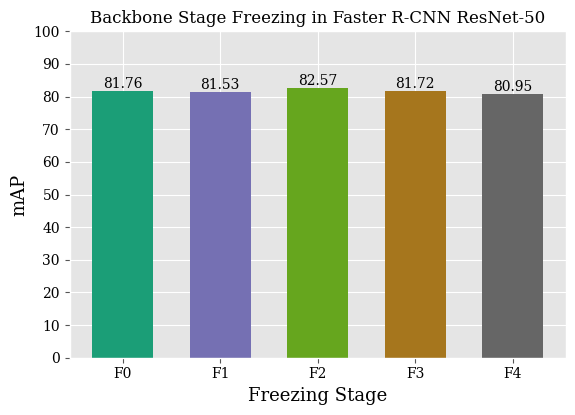

In [64]:
plot_metrics(
    file_paths,
    bar_width=1,
    colormap='Dark2',
    xlabel='Freezing Stage',
    ylabel='mAP',
    title='Backbone Stage Freezing in Faster R-CNN ResNet-50',
    title_wrap_width=50,
    x_labels=[f'F{i}' for i in range(len(file_paths))]
)

## Skewed Layout Effect 

In [65]:
run_ids = ['467d784b6de5416384202a8f2443765d', '915a0263bf6344df9da6213c07a52d62', 
           '0bd2d9d96cab42e4842dfc8609cc1b99']

fpath = 'artifacts/test-set-results'

if os.path.exists(fpath):
    shutil.rmtree(fpath)
    print(f"The folder {fpath} has been deleted.")
else:
    print(f"The folder {fpath} does not exist.")

file_to_fetch = 'test-set-results/coco-metrics.txt'
filename = 'coco-metrics.txt'
destination = 'artifacts/test-set-results/'


The folder artifacts/test-set-results has been deleted.


In [66]:
for index, run in enumerate(run_ids):
    # Downloading the artifacts from the current run
    mlflow.tracking.MlflowClient().download_artifacts(run, file_to_fetch, 'artifacts')

    # Renaming files
    old_file_path = os.path.join(destination, filename)
    new_filename = f"file_{index}_{filename}"
    new_file_path = os.path.join(destination, new_filename)
    os.rename(old_file_path, new_file_path)
    print(f"Renamed {old_file_path} to {new_file_path}")

Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_0_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_1_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_2_coco-metrics.txt


In [67]:
file_paths = ["artifacts/test-set-results/file_0_coco-metrics.txt", "artifacts/test-set-results/file_1_coco-metrics.txt", "artifacts/test-set-results/file_2_coco-metrics.txt"]

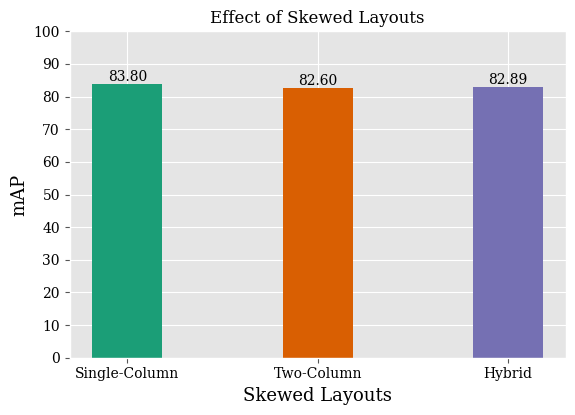

In [68]:
plot_metrics(
    file_paths,
    bar_width=0.35,
    custom_colors=['#1b9e77', '#d95f02', '#7570b3'],
    xlabel='Skewed Layouts',
    ylabel='mAP',
    title='Effect of Skewed Layouts',
    title_wrap_width=50,
    x_labels=["Single-Column", "Two-Column", "Hybrid"]
)

### Learning rate 

In [69]:
run_ids = ['282ab90ac8214d9481dbf2fd0ce9b5b6', 'bb87a9359ac84a8e8f64a51c4462982d', 
           'adc7afbfb6264424bfdbd0f31c9831d9', '24d5107bdaec49d09d85468b68ace4ed', '8419b1371c094711a727c77f158ef500']

fpath = 'artifacts/test-set-results'

if os.path.exists(fpath):
    shutil.rmtree(fpath)
    print(f"The folder {fpath} has been deleted.")
else:
    print(f"The folder {fpath} does not exist.")

file_to_fetch = 'test-set-results/coco-metrics.txt'
filename = 'coco-metrics.txt'
destination = 'artifacts/test-set-results/'

The folder artifacts/test-set-results has been deleted.


In [70]:
for index, run in enumerate(run_ids):
    # Downloading the artifacts from the current run
    mlflow.tracking.MlflowClient().download_artifacts(run, file_to_fetch, 'artifacts')

    # Renaming files
    old_file_path = os.path.join(destination, filename)
    new_filename = f"file_{index}_{filename}"
    new_file_path = os.path.join(destination, new_filename)
    os.rename(old_file_path, new_file_path)
    print(f"Renamed {old_file_path} to {new_file_path}")

Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_0_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_1_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_2_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_3_coco-metrics.txt


Renamed artifacts/test-set-results/coco-metrics.txt to artifacts/test-set-results/file_4_coco-metrics.txt


In [71]:
file_paths = ["artifacts/test-set-results/file_0_coco-metrics.txt", "artifacts/test-set-results/file_1_coco-metrics.txt", "artifacts/test-set-results/file_2_coco-metrics.txt", "artifacts/test-set-results/file_3_coco-metrics.txt", "artifacts/test-set-results/file_4_coco-metrics.txt"]

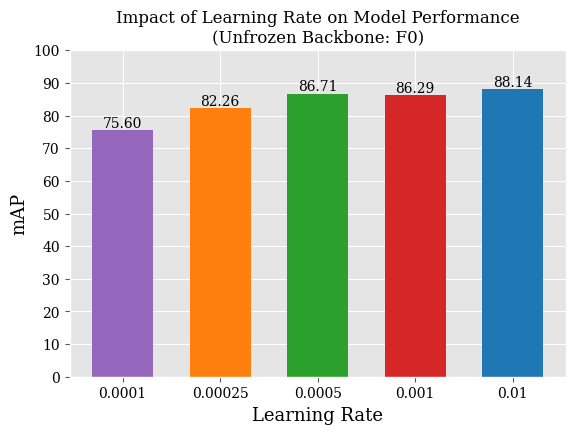

In [72]:
plot_metrics(
    file_paths,
    bar_width=1,
    colormap='Paired',
    custom_colors=['#9467bd', '#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'],
    xlabel='Learning Rate',
    ylabel='mAP',
    title='Impact of Learning Rate on Model Performance (Unfrozen Backbone: F0)',
    title_wrap_width=50,
    x_labels=["0.0001", "0.00025", "0.0005","0.001","0.01"]
)


##  Distribution of Classes

In [73]:
def combine_class_distributions(filenames):
    '''
    Combines class distributions from multiple files into a single dictionary.

    Args:
        filenames (list): List of filenames containing JSON data for datasets.

    Returns:
        dict: A dictionary representing the combined distribution of class counts for all datasets.
    '''
    
    # Initializing a dictionary to store the combined distribution
    combined_distribution = {}

    # Looping through each filename
    for filename in filenames:
        # Initializing a dictionary for the dataset
        dataset_distribution = {}

        # Loading JSON data from the file
        with open(filename, 'r') as file:
            data = json.load(file)

        # Extracting relevant data from JSON
        images = data['images']
        annotations = data['annotations']
        categories = data['categories']

        # Initializing class count dictionary for this dataset
        for category in categories:
            dataset_distribution[category['name']] = [0] * len(images)

        # Creating a mapping from image_id to index in the list
        image_id_to_index = {image['id']: idx for idx, image in enumerate(images)}

        # Counting the occurrences of each class per image
        for annotation in annotations:
            image_id = annotation['image_id']
            category_id = annotation['category_id']
            category_name = next(category['name'] for category in categories if category['id'] == category_id)

            image_index = image_id_to_index[image_id]
            dataset_distribution[category_name][image_index] += 1

        # Merging counts with the overall distribution
        for class_name, counts in dataset_distribution.items():
            if class_name not in combined_distribution:
                combined_distribution[class_name] = counts
            else:
                combined_distribution[class_name].extend(counts)

    return combined_distribution


In [74]:
def plot_distribution(filenames, phase=""):
    """
    Plots the distribution of occurrences for each class in the dataset.

    Args:
        filenames (list): List of filenames containing JSON data for datasets.
        phase (str, optional): Which phase the dataset belongs to.

    """
    dataset_distribution = combine_class_distributions(filenames)
    plt.style.use('ggplot')  # Set the plot style to 'ggplot'
    cmap = plt.get_cmap('Dark2')  # Use tab10 colormap for colors

    for i, (class_name, counts) in enumerate(dataset_distribution.items()):
        plt.figure(figsize=(15, 6))
        num_images = len(counts)

        plt.bar(np.arange(1, num_images + 1), counts, color=cmap(i)) 
        plt.title(f'Class Distribution of "{class_name}" ({phase})', fontsize=14, fontfamily='serif', color='black')
        plt.xlabel('Document Images', fontsize=13, fontfamily='serif', color='black', labelpad=10)
        plt.ylabel('Occurrences', fontsize=13, fontfamily='serif', color='black', labelpad=10)
        plt.tick_params(axis='both', colors='black', which='both', width=2)

        # Setting x-axis limits
        plt.xlim(0.5, num_images + 0.5)

        # Setting ggplot style
        plt.style.use('ggplot')

        # Setting font properties for ticks
        plt.xticks(fontsize=11, fontfamily='serif')
        plt.yticks(fontsize=11, fontfamily='serif')

        plt.grid(True)
        plt.show()

## Phase I Distribution 

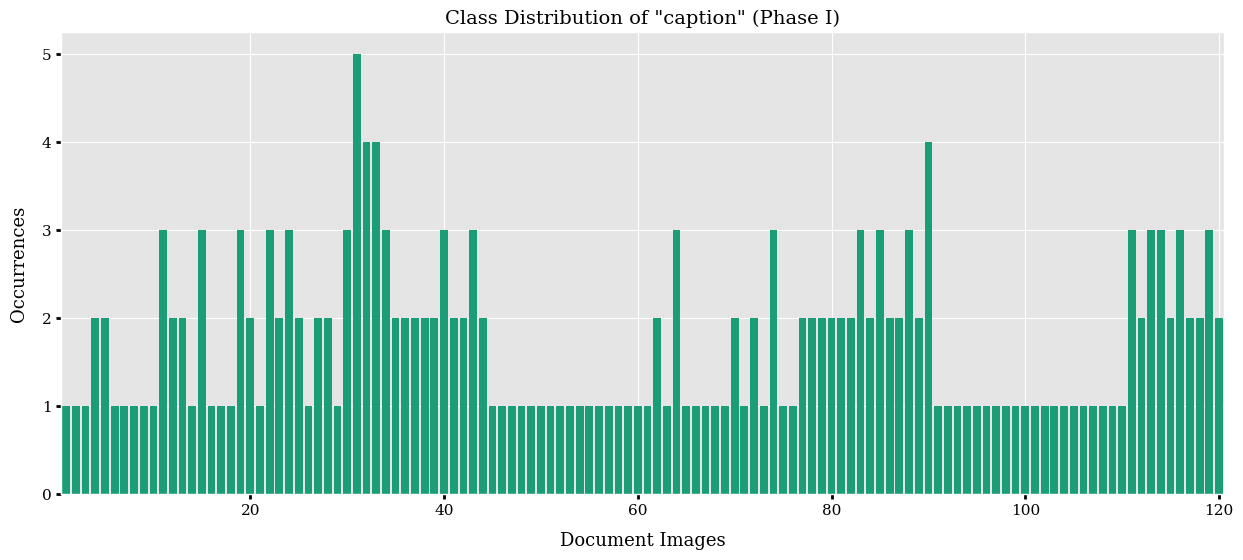

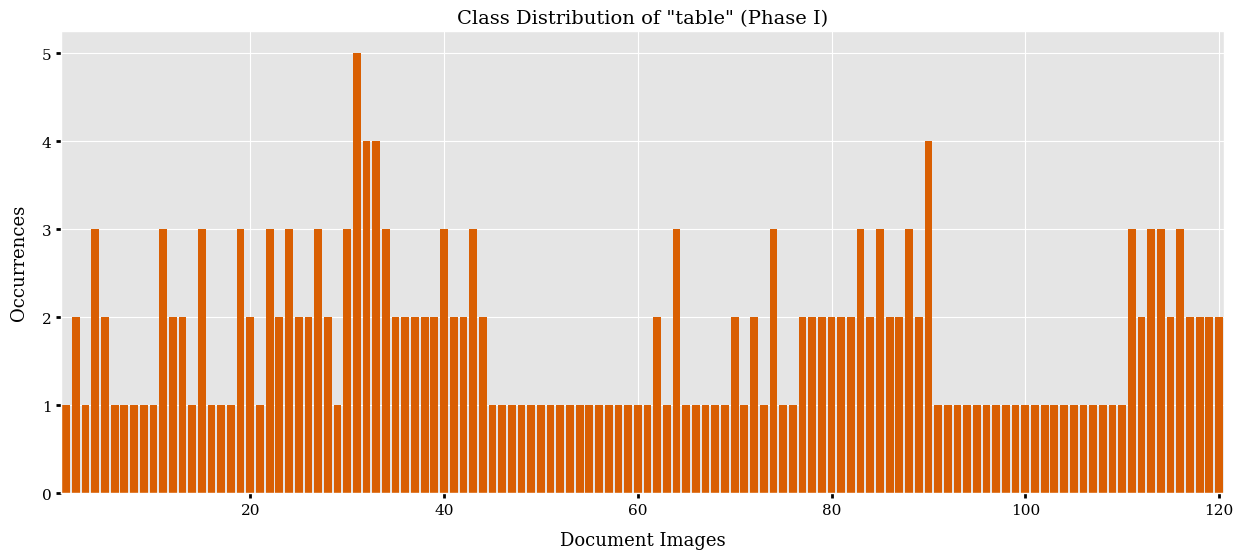

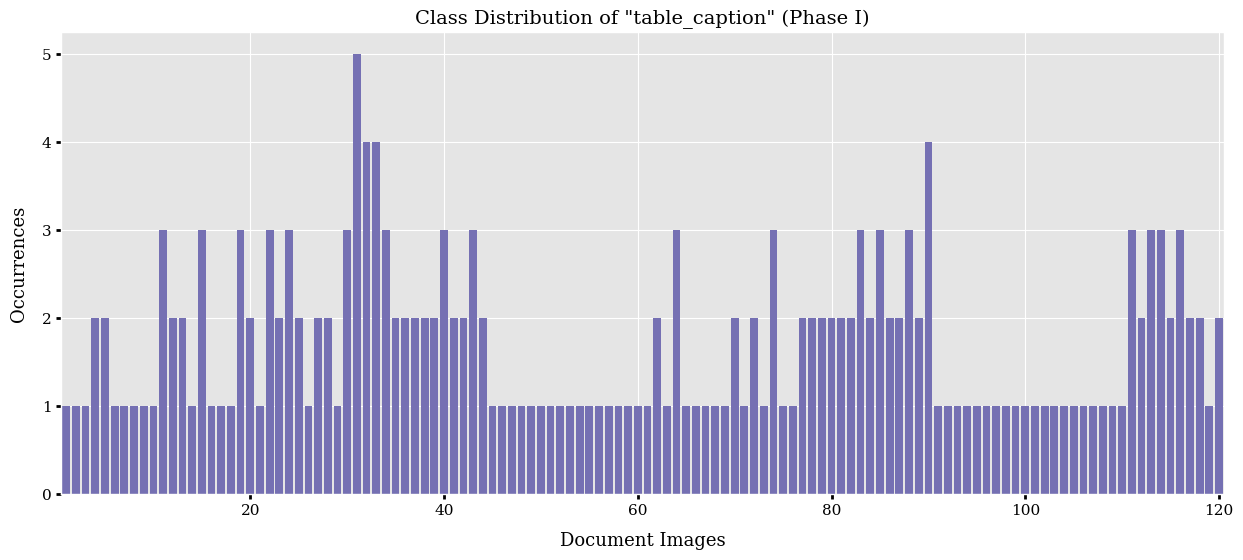

In [75]:
filenames = ["../data/Phase I/train.json", "../data/Phase I/val.json", "../data/Phase I/test.json"]
plot_distribution(filenames,phase="Phase I")

## Phase II Distribution

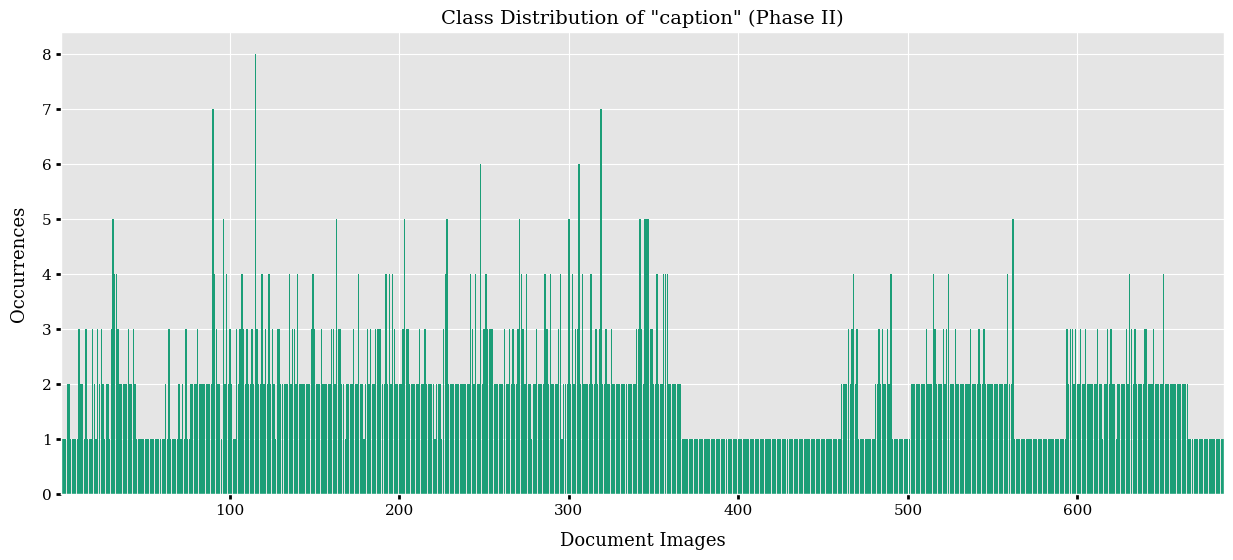

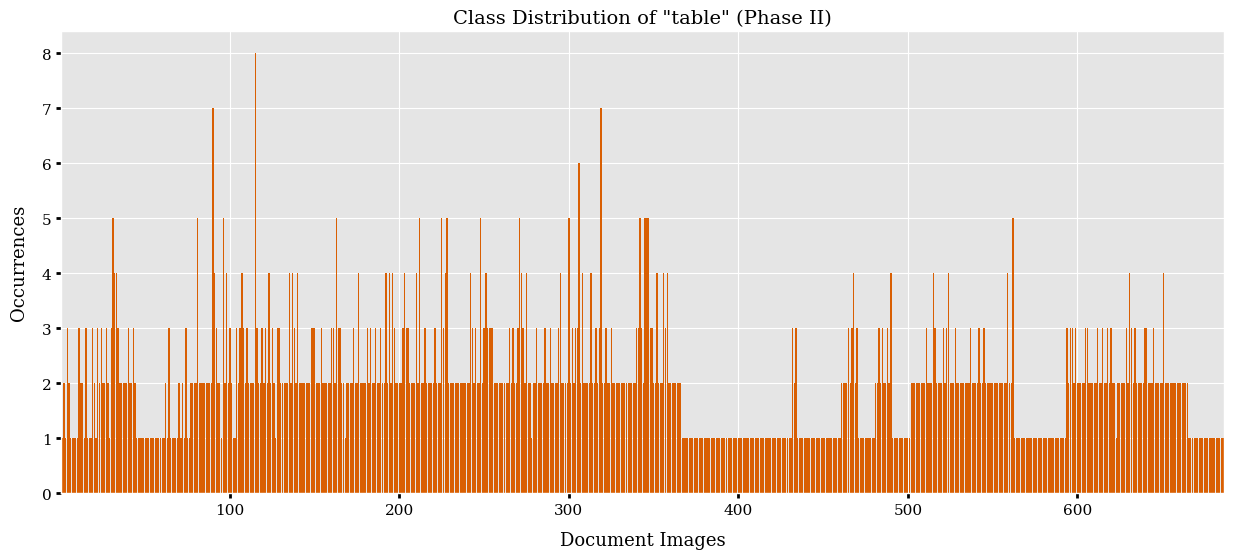

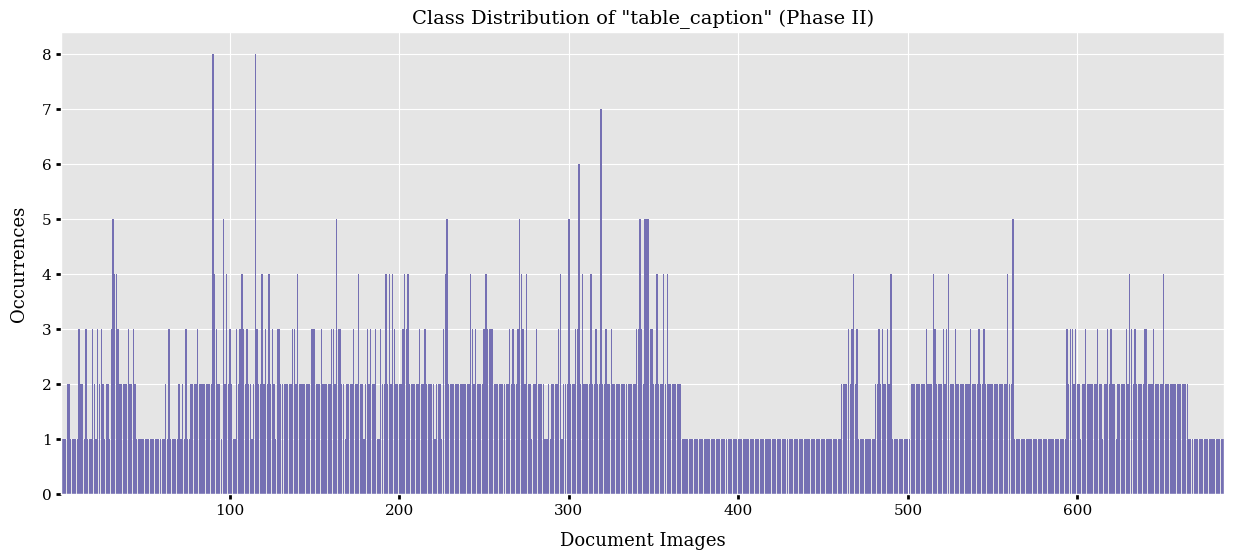

In [76]:
filenames = ["../data/Phase II/train.json", "../data/Phase II/val.json", "../data/Phase II/test.json"]
plot_distribution(filenames,phase="Phase II")

## Phase III Distribution

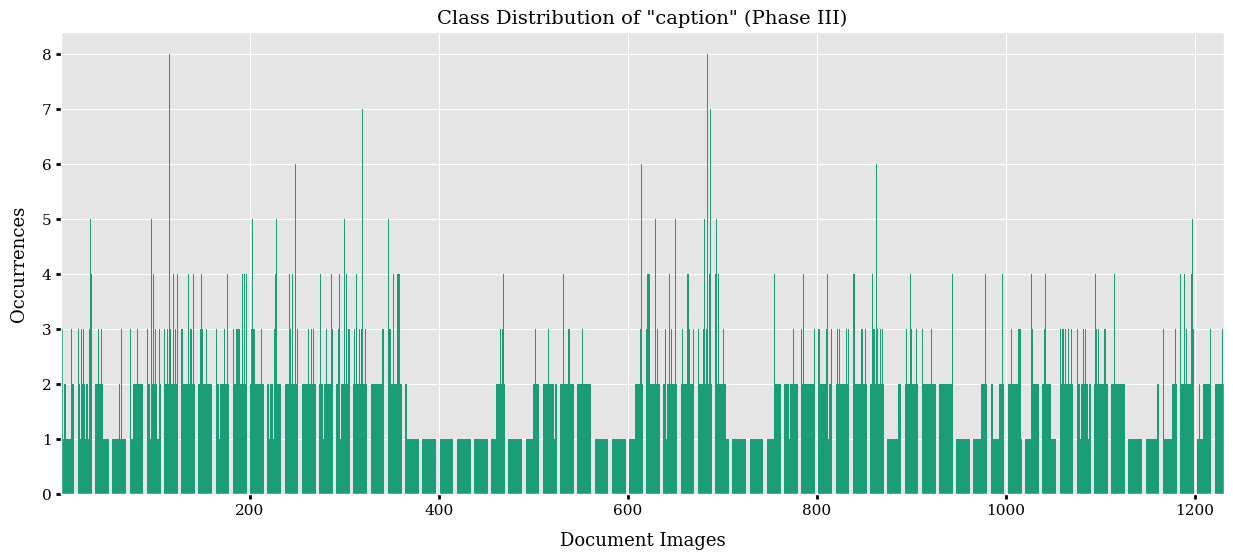

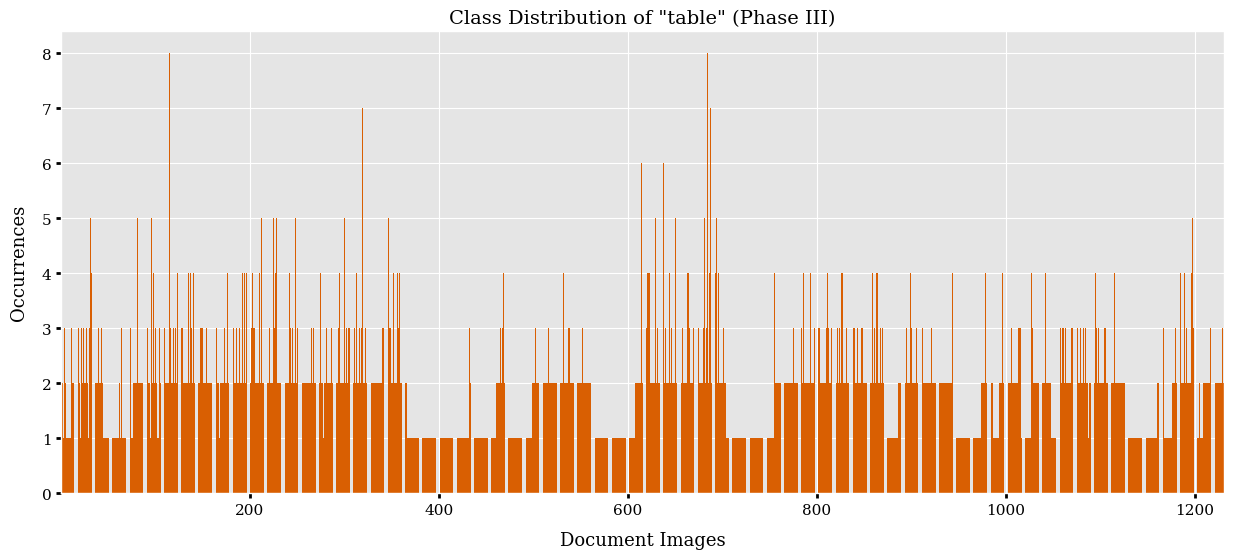

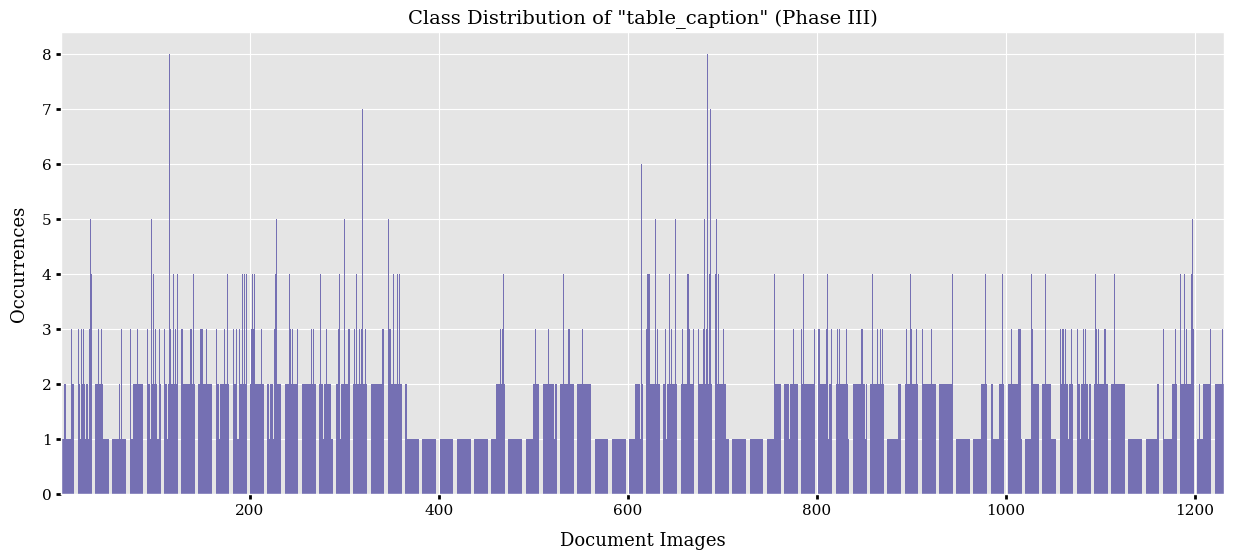

In [77]:
filenames = ["../data/Phase III/whole_dataset/faster/train_whole.json", "../data/Phase III//whole_dataset/faster/val_whole.json", "../data/Phase III//whole_dataset/faster/test_whole.json"]
plot_distribution(filenames,phase="Phase III")


## Plotting Different AP vs Iterations

In [78]:
def plot_all_ap_metrics(json_file, figure_title=""):
    """
    Function to plot all AP metrics from a JSON file generated by Detectron2.

    Args:
    - json_file (str): Path to the JSON file containing metrics.
    - figure_title (str, optional): Title for the plot.


    """
    # Load JSON data from file
    with open(json_file, 'r') as f:
        data = [json.loads(line) for line in f]

    # Initializing dictionaries to hold extracted data
    ap_metrics = {"bbox/AP": {}, "bbox/AP-caption": {}, "bbox/AP-table": {}, "bbox/AP-table_caption": {}}

    # Extracting the data
    for entry in data:
        if all(key in entry for key in ["iteration", "bbox/AP", "bbox/AP-caption", "bbox/AP-table", "bbox/AP-table_caption"]):
            iteration = entry["iteration"]
            ap_metrics["bbox/AP"][iteration] = entry["bbox/AP"]
            ap_metrics["bbox/AP-caption"][iteration] = entry["bbox/AP-caption"]
            ap_metrics["bbox/AP-table"][iteration] = entry["bbox/AP-table"]
            ap_metrics["bbox/AP-table_caption"][iteration] = entry["bbox/AP-table_caption"]

    # Getting unique iterations
    unique_iterations = sorted(ap_metrics["bbox/AP"].keys())

    # Extracting AP metrics lists
    bbox_ap = [ap_metrics["bbox/AP"][iteration] for iteration in unique_iterations]
    bbox_ap_caption = [ap_metrics["bbox/AP-caption"][iteration] for iteration in unique_iterations]
    bbox_ap_table = [ap_metrics["bbox/AP-table"][iteration] for iteration in unique_iterations]
    bbox_ap_table_caption = [ap_metrics["bbox/AP-table_caption"][iteration] for iteration in unique_iterations]

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.style.use('ggplot')
    
    cmap = plt.get_cmap('tab10')
    
    # Plotting each AP metric with lines connecting the points
    plt.plot(unique_iterations, bbox_ap, label='mAP', color=cmap(0))
    plt.plot(unique_iterations, bbox_ap_caption, label='AP-caption', color=cmap(1))
    plt.plot(unique_iterations, bbox_ap_table, label='AP-table', color=cmap(2))
    plt.plot(unique_iterations, bbox_ap_table_caption, label='AP-table_caption', color=cmap(3))

    # Adding labels and title
    plt.xlabel('Iterations', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'},labelpad=15)
    plt.ylabel('Average Precision (AP)', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'},labelpad=15)
    wrapped_title = wrap_text(figure_title, 50)  # Adjust the width as necessary
    plt.title(wrapped_title, fontsize=13, fontfamily='serif', color='black')

    # Setting font properties for ticks
    plt.xticks(fontsize=11, fontfamily='serif', color='black')
    plt.yticks(np.arange(0, max(max(bbox_ap), max(bbox_ap_caption), max(bbox_ap_table), max(bbox_ap_table_caption))+1, 10), fontsize=11, fontfamily='serif', color='black')

    # Adding grid
    plt.grid(True)

    # Adding legend
    legend = plt.legend(loc='best', fontsize=10)
    for text in legend.get_texts():
        text.set_fontfamily('serif')
        text.set_color('black')

    plt.show()

In [79]:
def plot_all_ap_metrics(json_file, figure_title=""):
    """
    Function to plot all AP metrics from a JSON file generated by Detectron2.

    Args:
    - json_file (str): Path to the JSON file containing metrics.
    - figure_title (str, optional): Title for the plot.
    
    """
    # Load JSON data from file
    with open(json_file, 'r') as f:
        data = [json.loads(line) for line in f]

    # Initializing dictionaries to hold extracted data
    ap_metrics = {"bbox/AP": {}, "bbox/AP-caption": {}, "bbox/AP-table": {}, "bbox/AP-table_caption": {}}

    # Extracting the data
    for entry in data:
        if all(key in entry for key in ["iteration", "bbox/AP", "bbox/AP-caption", "bbox/AP-table", "bbox/AP-table_caption"]):
            iteration = entry["iteration"]
            ap_metrics["bbox/AP"][iteration] = entry["bbox/AP"]
            ap_metrics["bbox/AP-caption"][iteration] = entry["bbox/AP-caption"]
            ap_metrics["bbox/AP-table"][iteration] = entry["bbox/AP-table"]
            ap_metrics["bbox/AP-table_caption"][iteration] = entry["bbox/AP-table_caption"]

    # Getting unique iterations
    unique_iterations = sorted(ap_metrics["bbox/AP"].keys())

    # Extracting AP metrics lists
    bbox_ap = [ap_metrics["bbox/AP"][iteration] for iteration in unique_iterations]
    bbox_ap_caption = [ap_metrics["bbox/AP-caption"][iteration] for iteration in unique_iterations]
    bbox_ap_table = [ap_metrics["bbox/AP-table"][iteration] for iteration in unique_iterations]
    bbox_ap_table_caption = [ap_metrics["bbox/AP-table_caption"][iteration] for iteration in unique_iterations]

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.style.use('ggplot')  

    # Defining line styles
    line_styles = ['-', '--', '-.', ':']
    cmap = plt.get_cmap('tab10')


    # Plotting each AP metric with different line styles
    plt.plot(unique_iterations, bbox_ap, label='mAP', color=cmap(0), linestyle=line_styles[0])
    plt.plot(unique_iterations, bbox_ap_caption, label='AP-caption', color=cmap(1), linestyle=line_styles[1])
    plt.plot(unique_iterations, bbox_ap_table, label='AP-table', color=cmap(2), linestyle=line_styles[2])
    plt.plot(unique_iterations, bbox_ap_table_caption, label='AP-table_caption', color=cmap(3), linestyle=line_styles[3])

    # Adding labels and title
    plt.xlabel('Iterations', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'}, labelpad=15)
    plt.ylabel('Average Precision (AP)', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'}, labelpad=15)
    wrapped_title = wrap_text(figure_title, 50)  # Adjust the width as necessary
    plt.title(wrapped_title, fontsize=13, fontfamily='serif', color='black')

    # Setting font properties for ticks
    plt.xticks(fontsize=11, fontfamily='serif', color='black')
    plt.yticks(np.arange(0, max(max(bbox_ap), max(bbox_ap_caption), max(bbox_ap_table), max(bbox_ap_table_caption))+1, 10), fontsize=11, fontfamily='serif', color='black')

    plt.grid(True)

    legend = plt.legend(loc='best', fontsize=10)
    for text in legend.get_texts():
        text.set_fontfamily('serif')
        text.set_color('black')

    plt.show()


In [80]:
run_id = '8419b1371c094711a727c77f158ef500' # Run ID for Optimal Model
mlflow.tracking.MlflowClient().download_artifacts(run_id, 'metrics.json', 'artifacts')

'/mnt/beegfs/home/aashishk/for_github/notebooks/artifacts/metrics.json'

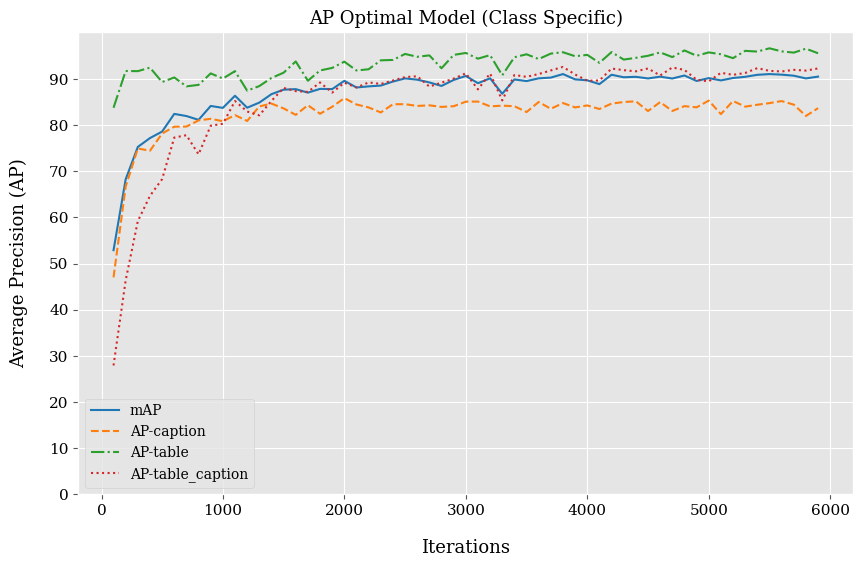

In [81]:
plot_all_ap_metrics('artifacts/metrics.json', "AP Optimal Model (Class Specific) ")

## Model Comparison

In [82]:
def plot_mAP_multiple(json_files, legend_labels=None, figure_title=""):
    """
    Function to plot the mean Average Precision (mAP) from multiple JSON files generated by Detectron2.

    Args:
    - json_files (list): List of paths to the JSON files containing metrics.
    - legend_labels (list, optional): List of legend labels for each file.
    - figure_title (str, optional): Title for the plot.

    """
    # Initializing lists to hold mAP data from each file
    all_bboxes_ap = []

    # Setting default legend labels if not provided
    if legend_labels is None:
        legend_labels = [f"File {i+1}" for i in range(len(json_files))]

    # Iterating through each JSON file
    for json_file in json_files:
        # Load JSON data from file
        with open(json_file, 'r') as f:
            data = [json.loads(line) for line in f]

        # Initializing dictionary to hold extracted data
        ap_metrics = {"bbox/AP": {}}

        # Extracting the data
        for entry in data:
            if all(key in entry for key in ["iteration", "bbox/AP"]):
                iteration = entry["iteration"]
                ap_metrics["bbox/AP"][iteration] = entry["bbox/AP"]

        # Getting unique iterations
        unique_iterations = sorted(ap_metrics["bbox/AP"].keys())

        # Extracting mAP
        bbox_ap = [ap_metrics["bbox/AP"][iteration] for iteration in unique_iterations]

        # Append mAP data to the list
        all_bboxes_ap.append((unique_iterations, bbox_ap))

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.style.use('ggplot')  # Set the plot style to 'ggplot'
    
    # Defining line styles
    line_styles = ['-', '--', '-.', ':']
    cmap = plt.get_cmap('Dark2')

    # Plotting mAP for each file
    for i, (unique_iterations, bbox_ap) in enumerate(all_bboxes_ap):
        plt.plot(unique_iterations, bbox_ap, label=legend_labels[i], color=cmap(i), linestyle=line_styles[i % len(line_styles)])

    # Adding labels and title
    plt.xlabel('Iterations', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'}, labelpad=15)
    plt.ylabel('Mean Average Precision (mAP)', fontdict={'fontsize': 13, 'fontfamily': 'serif', "color": 'black'}, labelpad=15)
    wrapped_title = wrap_text(figure_title, 50)  # Adjust the width as necessary
    plt.title(wrapped_title, fontsize=14, fontfamily='serif', color='black')

    # Setting font properties for ticks
    plt.xticks(fontsize=11, fontfamily='serif', color='black')
    plt.yticks(np.arange(0, max(max(bbox_ap) for _, bbox_ap in all_bboxes_ap) + 1, 10), fontsize=11, fontfamily='serif', color='black')

    # Adding grid
    plt.grid(True)

    # Adding legend
    legend = plt.legend(loc='best', fontsize=10)
    for text in legend.get_texts():
        text.set_fontfamily('serif')
        text.set_color('black')

    # Displaying the plot
    plt.show()


In [83]:
run_ids = ['8419b1371c094711a727c77f158ef500', 'f0688e7a14774e7087eb9aff65b4be19', 
           '60b4e2f11e63413d9b98412ac755a125', '2bcd6df553ec4331983cf9127f724cda']

fpath = 'artifacts/metrics.json'

if os.path.isfile(fpath):
    os.remove(fpath)
    print(f"The file {fpath} has been deleted.")
else:
    print(f"The file {fpath} does not exist.")

file_to_fetch = 'metrics.json'
filename = 'metrics.json'
destination = 'artifacts'

for index, run in enumerate(run_ids):
    # Downloading the artifacts from the current run
    mlflow.tracking.MlflowClient().download_artifacts(run, file_to_fetch, 'artifacts')

    # Renaming files
    old_file_path = os.path.join(destination, filename)
    new_filename = f"file_{index}_{filename}"
    new_file_path = os.path.join(destination, new_filename)
    os.rename(old_file_path, new_file_path)
    print(f"Renamed {old_file_path} to {new_file_path}")

The file artifacts/metrics.json has been deleted.


Renamed artifacts/metrics.json to artifacts/file_0_metrics.json


Renamed artifacts/metrics.json to artifacts/file_1_metrics.json


Renamed artifacts/metrics.json to artifacts/file_2_metrics.json


Renamed artifacts/metrics.json to artifacts/file_3_metrics.json


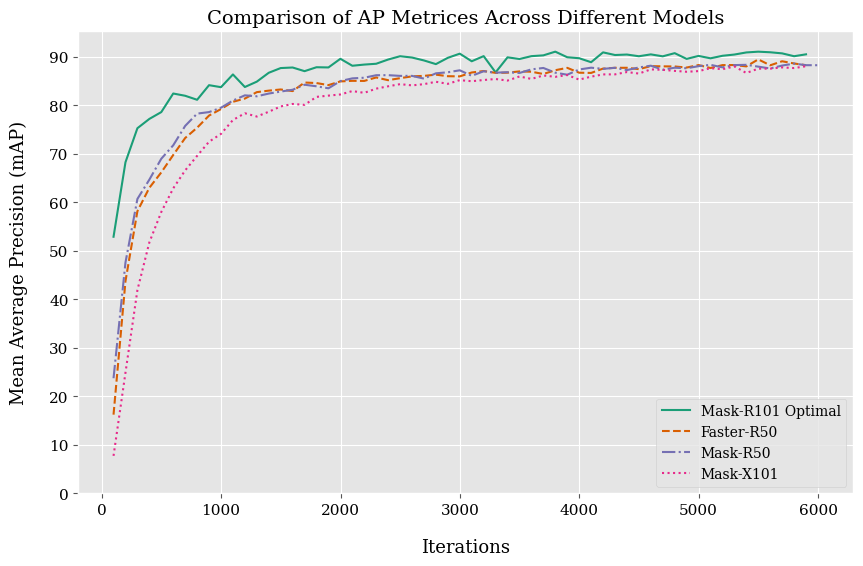

In [84]:
plot_mAP_multiple(['artifacts/file_0_metrics.json', 'artifacts/file_1_metrics.json',"artifacts/file_2_metrics.json","artifacts/file_3_metrics.json"],["Mask-R101 Optimal", "Faster-R50", "Mask-R50", "Mask-X101"], figure_title="Comparison of AP Metrices Across Different Models")